###Import

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import os
from datasets import Dataset, DatasetDict, Image
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###Utils

In [3]:
# Creating mapping between id and label
id2label = {0: 'sky',
            1:'building',
            2:'pole',
            3: 'road',
            4:'pavement',
            5: 'tree',
            6: 'signsymbol',
            7: 'fence',
            8: 'car',
            9: 'pedestrian',
            10: 'bicyclist',
            11: 'unlabelled'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

def plot_segmentation_map(segmentation_map):

    n_classes = len(id2label)
    cmap = plt.get_cmap('tab20', n_classes)
    norm = mcolors.BoundaryNorm(np.arange(n_classes + 1) - 0.5, n_classes)

    plt.figure(figsize=(10, 10))
    plt.imshow(segmentation_map, cmap=cmap, norm=norm)

    cbar = plt.colorbar(ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels([id2label[i] for i in range(n_classes)])

    plt.title("Segmentation Map")
    plt.show()


###Download dataset
CamVid Image Segmentation dataset. 360x480 RGB street scenes images.

In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

###Creating a DatasetDict
The DatasetDict dataset will be used to create a PyTorch dataset to be used in the fine-tuning process.

In [6]:
def create_dataset(image_paths, label_paths):
  dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
  dataset = dataset.cast_column("image", Image())
  dataset = dataset.cast_column("label", Image())

  return dataset


In [7]:
train_image_paths = os.listdir(x_train_dir)
train_image_paths = [os.path.join(x_train_dir, file_name) for file_name in train_image_paths]
train_label_paths = os.listdir(y_train_dir)
train_label_paths = [os.path.join(y_train_dir, file_name) for file_name in train_label_paths]

val_image_paths = os.listdir(x_valid_dir)
val_image_paths = [os.path.join(x_valid_dir, file_name) for file_name in val_image_paths]
val_label_paths = os.listdir(y_valid_dir)
val_label_paths = [os.path.join(y_valid_dir, file_name) for file_name in val_label_paths]

test_image_paths = os.listdir(x_test_dir)
test_image_paths = [os.path.join(x_test_dir, file_name) for file_name in test_image_paths]
test_label_paths = os.listdir(y_test_dir)
test_label_paths = [os.path.join(y_test_dir, file_name) for file_name in test_label_paths]

train_ds = create_dataset(train_image_paths, train_label_paths)
val_ds = create_dataset(val_image_paths, val_label_paths)
test_ds = create_dataset(test_image_paths, test_label_paths)

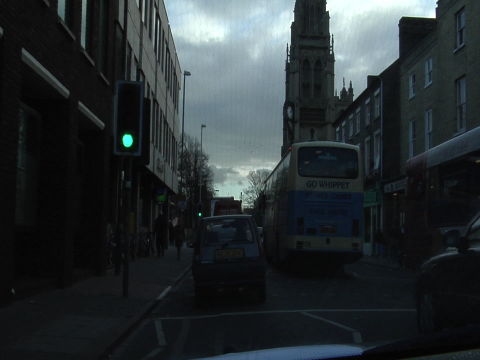

In [8]:
example = train_ds[1]
example['image']

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11]], dtype=uint8)
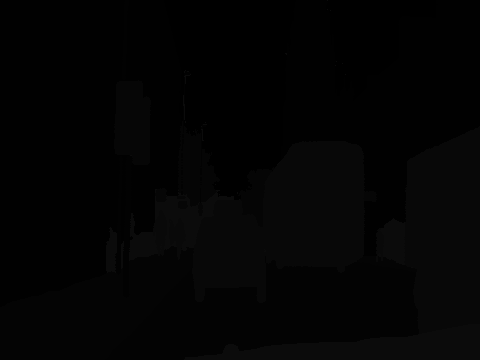

In [9]:
# An exemple of segmentation map
segmentation_map = np.array(example['label'])
segmentation_map

In [10]:
np.unique(segmentation_map)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11], dtype=uint8)

In [11]:
# List of labels present in the image
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'car', 'pedestrian', 'unlabelled']


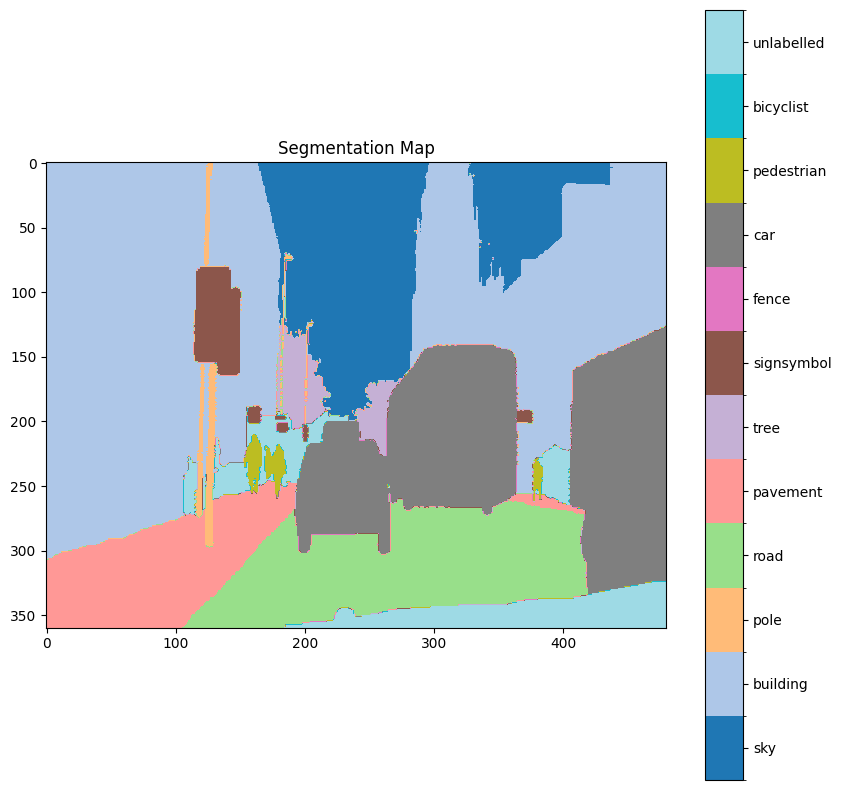

In [12]:
# Visualizing the segmentation map
plot_segmentation_map(segmentation_map)

###PyTorch Dataset

In [13]:
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

####Data Augmentation  

In [14]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.Perspective(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ###May add more transformations
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
val_dataset = ImageSegmentationDataset(val_ds, transform=test_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [15]:
image, segmentation_map, _, _ = train_dataset[0]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


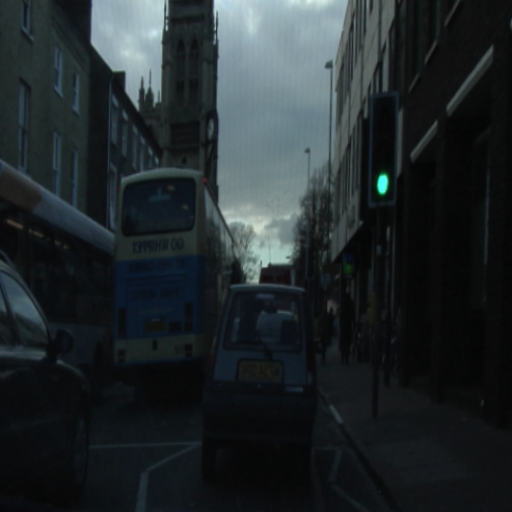

In [16]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
segmentation_map.shape

(512, 512)

In [18]:
# List of labels present in the image
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)


['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'car', 'pedestrian', 'unlabelled']


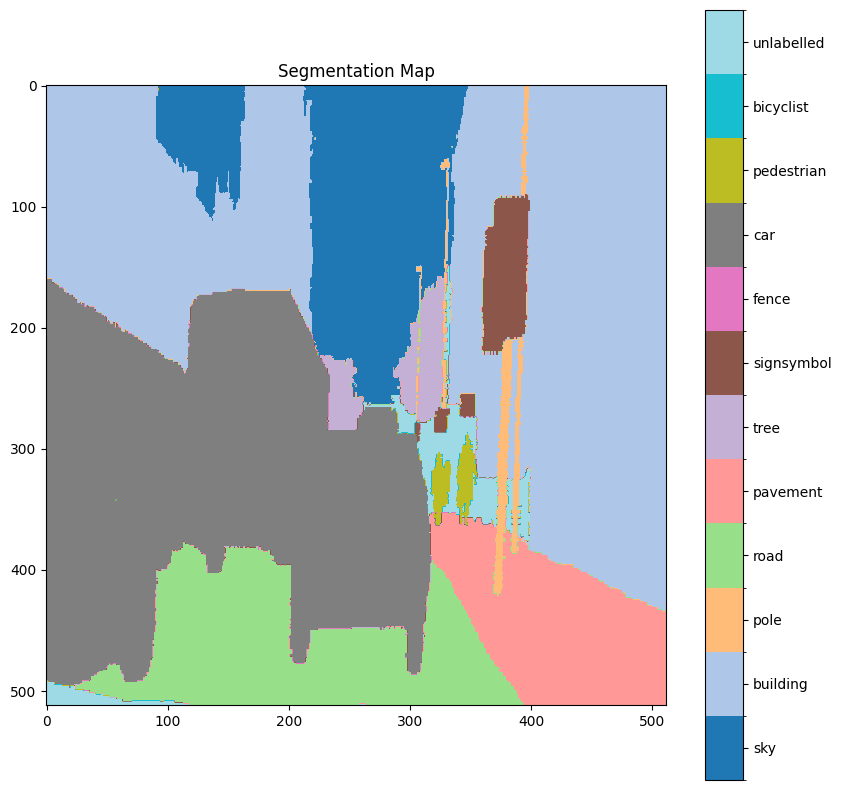

In [19]:
plot_segmentation_map(segmentation_map)

###Data Loader

In [20]:
from transformers import MaskFormerImageProcessor

preprocessor = MaskFormerImageProcessor(
    #Specify class labell to assign to background
    ignore_index=11,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False)


In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


####Checking correct input

In [22]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels torch.Size([9, 512, 512])
class_labels torch.Size([9])
original_images (360, 480, 3)
original_segmentation_maps (360, 480)


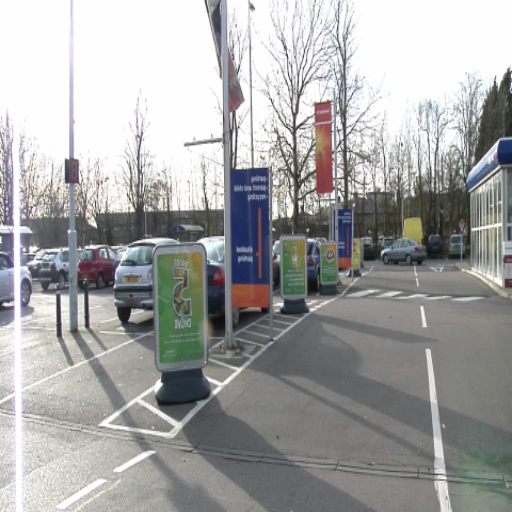

In [23]:
pixel_values = batch['pixel_values'][0].numpy()
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [24]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car']


In [25]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: car


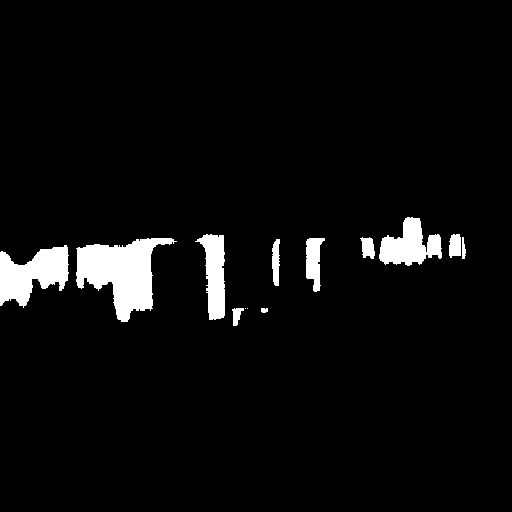

In [27]:
visualize_mask(labels, 'car')

###MaskFormer

In [28]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Function to count the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate the size of the model in megabytes
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    return size_all_mb

# Get the total number of parameters
num_params = count_parameters(model)
print(f'Total number of parameters: {num_params}')

# Get the size of the model
model_size = get_model_size(model)
print(f'Model size: {model_size:.2f} MB')


Total number of parameters: 101795973
Model size: 392.12 MB


####Fine-tuning

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip show evaluate

Name: evaluate
Version: 0.4.2
Summary: HuggingFace community-driven open-source library of evaluation
Home-page: https://github.com/huggingface/evaluate
Author: HuggingFace Inc.
Author-email: leandro@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: datasets, dill, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, requests, tqdm, xxhash
Required-by: 


In [ ]:
import torch
from tqdm.auto import tqdm
import evaluate

metric = evaluate.load("mean_iou")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(15):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(val_dataloader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 11)['mean_iou'])


Epoch: 0


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 1.7190308570861816
Loss: 0.5813557691503279


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.732152658037437
Epoch: 1


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.4613375394809537
Loss: 0.394499890466985


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7348939580541686
Epoch: 2


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.36423183629370254
Loss: 0.3382963762960882


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7798800936570213
Epoch: 3


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.32289683289238247
Loss: 0.30777379568503255


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.781168465030845
Epoch: 4


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.2980619926233681
Loss: 0.28832364075198147


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7698790955714899
Epoch: 5


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.2817725645632736
Loss: 0.27467940922572326


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7881469151874211
Epoch: 6


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.2700953288324948
Loss: 0.2651920660264083


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7828961991299607
Epoch: 7


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.26287330904390876
Loss: 0.25926074356604295


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7875609794888908
Epoch: 8


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.25581772445902035
Loss: 0.25195061999038953


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7769727383558851
Epoch: 9


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.24869442282754606
Loss: 0.2450217120572606


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7884947142301837
Epoch: 10


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.24228741541050358
Loss: 0.23903125008829862


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7946286897700005
Epoch: 11


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.23655479272408308
Loss: 0.23372268459163598


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.799072459426397
Epoch: 12


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.23169011479269846
Loss: 0.22915130646602516


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.8003667242451825
Epoch: 13


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.2274153426136582
Loss: 0.2249584508845918


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7979886241823685
Epoch: 14


  0%|          | 0/184 [00:00<?, ?it/s]

Loss: 0.2234130786753582
Loss: 0.22148344956254692


  0%|          | 0/51 [00:00<?, ?it/s]

Mean IoU: 0.7961339828609262


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add any other information you want to save
}, './trained_mask_former.pth')

###Example of Inference


In [ ]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels 2
class_labels 2
original_images 2
original_segmentation_maps 2


In [ ]:
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [ ]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

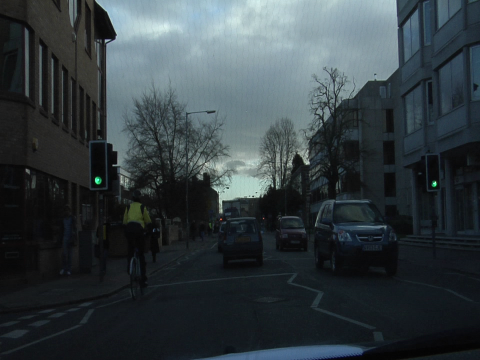

In [ ]:
image = batch["original_images"][0]
Image.fromarray(image)

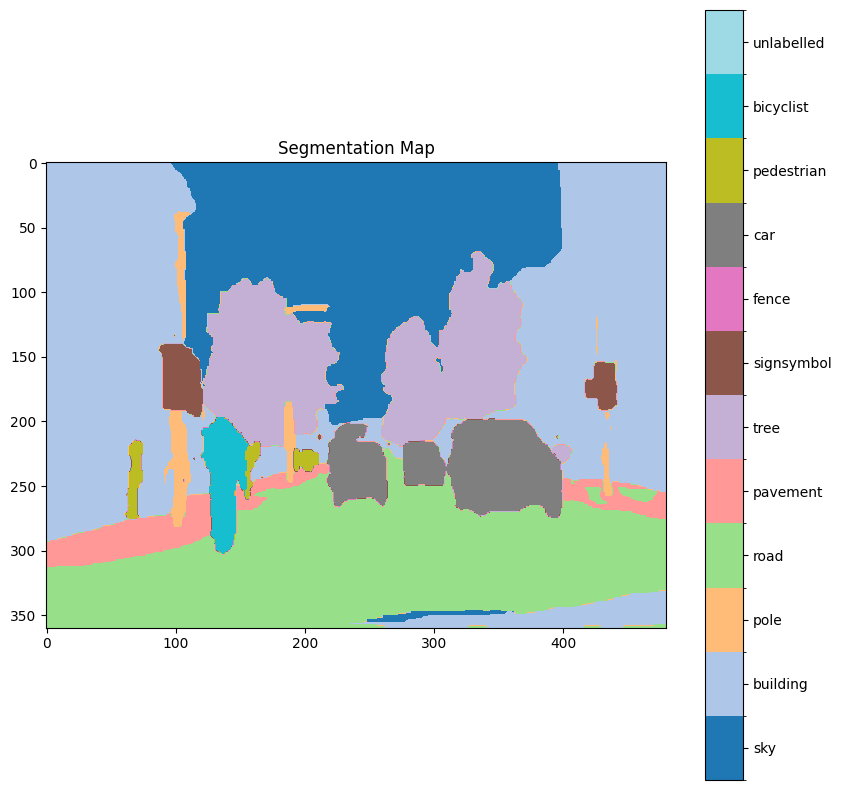

In [ ]:
#Predicetd mask
segmentation_map = predicted_segmentation_maps[0].cpu().numpy()
plot_segmentation_map(segmentation_map)

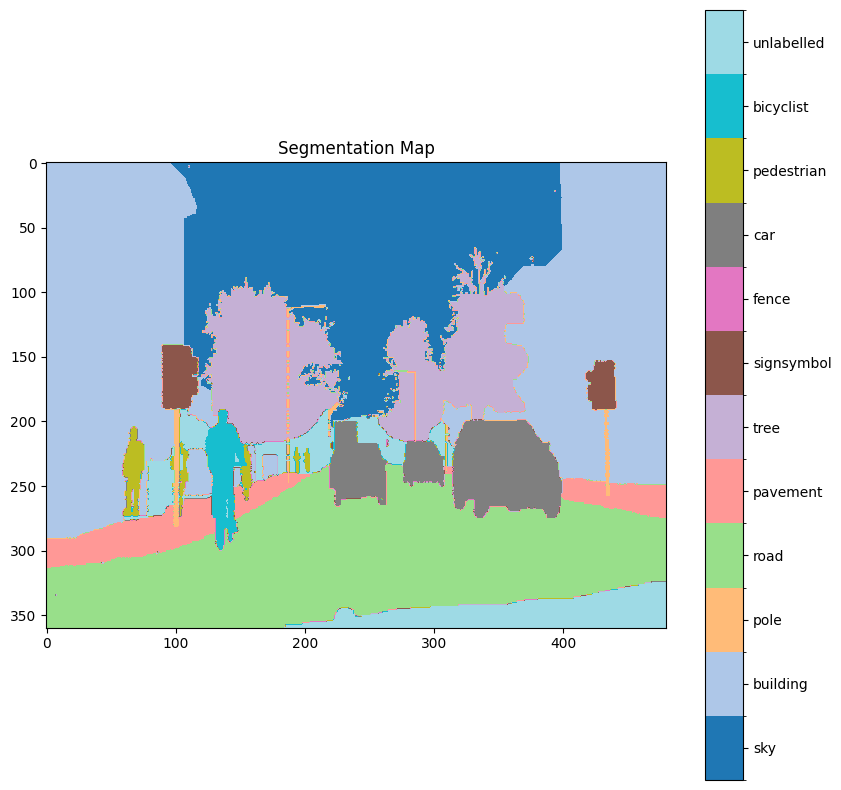

In [ ]:
#Ground truth
segmentation_map = batch["original_segmentation_maps"][0]
plot_segmentation_map(segmentation_map)

###Test set evaluation


####Load
Loading trained transformers from google drive.

In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Downloading model from HugginFace

from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Initialize optimizer
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [33]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/mask_former'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/mask_former


In [ ]:
# Load the model
checkpoint = torch.load('trained_mask_former.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# Put model in evaluation mode
model.eval()

####Evaluation

In [ ]:
import evaluate

mean_iou = evaluate.load("mean_iou")
# f1_score = evaluate.load("f1")

In [ ]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for idx, batch in enumerate(tqdm(test_dataloader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    mean_iou.add_batch(references=ground_truth_segmentation_maps,
                       predictions=predicted_segmentation_maps)
    # f1_score.add_batch(references=list(ground_truth_segmentation_maps),
    #                    predictions=list(predicted_segmentation_maps))

mean_iou_results = mean_iou.compute(num_labels = len(id2label), ignore_index = 11)
# NOTE this metric outputs a dict that also includes the mIoU per category as keys
# so if you're interested, feel free to print them as well
# print("Mean IoU:", mean_iou.compute(num_labels = len(id2label), ignore_index = 11)['mean_iou'])
# print("Mean IoU:", mean_iou.compute(num_labels = len(id2label), ignore_index = 11)['per_category_iou'])


  0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
print("Mean IoU: ", mean_iou_results['mean_iou'])

Mean IoU:  0.727715703292543


In [ ]:
for i, score in enumerate(mean_iou_results['per_category_iou']):
  print(id2label[i], " IoU: ", score)

sky  IoU:  0.9180685757049188
building  IoU:  0.869994172592002
pole  IoU:  0.3355469327251648
road  IoU:  0.9650170449310524
pavement  IoU:  0.8796842145671208
tree  IoU:  0.7988582385497015
signsymbol  IoU:  0.5563939215646493
fence  IoU:  0.4966106710888755
car  IoU:  0.913792525517106
pedestrian  IoU:  0.6216143730186473
bicyclist  IoU:  0.6492920659587327
unlabelled  IoU:  nan


In [ ]:
for key, value in mean_iou_results.items():
        if isinstance(value, np.ndarray):
            mean_iou_results[key] = value.tolist()
with open('data.json', 'w') as json_file:
    json.dump(mean_iou_results, json_file)

###CPU inference time

In [38]:
# Load the model and map to CPU
checkpoint = torch.load('trained_mask_former.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# Put model in evaluation mode
model.eval()

MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): MaskFormerSwinBackbone(
        (model): MaskFormerSwinModel(
          (embeddings): MaskFormerSwinEmbeddings(
            (patch_embeddings): MaskFormerSwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): MaskFormerSwinEncoder(
            (layers): ModuleList(
              (0): MaskFormerSwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x MaskFormerSwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): MaskFormerSwinAttention(
                      (self): MaskFormerSwinSelfAttention(
                        (query): Linear(in_

In [43]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


In [44]:
import evaluate
from tqdm.auto import tqdm
import time

mean_iou = evaluate.load("mean_iou")
# f1_score = evaluate.load("f1")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start = time.time()
for idx, batch in enumerate(tqdm(test_dataloader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    mean_iou.add_batch(references=ground_truth_segmentation_maps,
                       predictions=predicted_segmentation_maps)
    # f1_score.add_batch(references=list(ground_truth_segmentation_maps),
    #                    predictions=list(predicted_segmentation_maps))
end = time.time()
print("CPU inference time:", end - start)

  0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


CPU inference time: 762.3196399211884
